In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import dump as jdump
import time
import random
import os

In [2]:
PATH2PROJECT = "/content/drive/MyDrive/Projects/EyeTracker/"
raw_models_dir = PATH2PROJECT + "models/eye_tracking/raw/"
trained_models_dir = PATH2PROJECT + "models/eye_tracking/trained/"
MODEL_NUM = 4
scaler_dir = PATH2PROJECT + f"models/eye_tracking/trained/scalers{MODEL_NUM}.bin"
R_TRAIN = 0.85
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
N_EPOCHS = 100
PATIENCE = 8
MIN_BRIGHTNESS_RATIO = 0.7
MAX_BRIGHTNESS_RATIO = 1.4

In [3]:
x1_load = []
x2_load = []
y_load = []
dataset_dir = PATH2PROJECT + "dataset/"
datasets_folders = os.listdir(dataset_dir)

for data_fol in datasets_folders:
    with open(dataset_dir + data_fol +
              "/eye_tracking data-calibration/x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking data-calibration/x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking data-calibration/y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_smp, frame_height, frame_width = x1_load.shape[:-1]
print(n_smp, frame_height, frame_width)

24500 48 44


In [4]:
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(MIN_BRIGHTNESS_RATIO, MAX_BRIGHTNESS_RATIO)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [5]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

In [6]:
import matplotlib.pyplot as plt

[-2.92097984  0.01450496 -0.1692337   0.51821423  0.47875661  0.51987594
  0.49142322]
[2995.  948.]


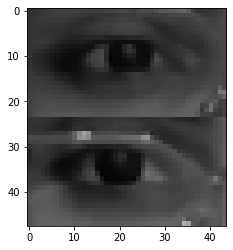

In [7]:
SAMPLE_NUMBER = 2
print(x2_chs_inp[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_chg_bri[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [8]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]
jdump(scalers, scaler_dir)

['/content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/scalers4.bin']

In [9]:
x1_shf, x2_shf, yx_shf, yy_shf = shuffle(x1, x2, y[:, 0], y[:, 1])

n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
yx_train, yy_train = yx_shf[:n_train], yy_shf[:n_train]
yx_test, yy_test = yx_shf[n_train:], yy_shf[n_train:]

x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

print(x1_train.shape, x1_test.shape, yx_train.shape, yx_test.shape,
      x2_train.shape, x2_test.shape, yy_train.shape, yy_test.shape)

(20825, 48, 44, 1) (3675, 48, 44, 1) (20825,) (3675,) (20825, 7) (3675, 7) (20825,) (3675,)


In [10]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [11]:
model_x = load_model(raw_models_dir + f"model{MODEL_NUM}_x")
model_y = load_model(raw_models_dir + f"model{MODEL_NUM}_y")
print(model_x.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [12]:
results_x = model_x.fit(x_train_list,
                       yx_train,
                       validation_data=(x_test_list, yx_test),
                       epochs=N_EPOCHS,
                       callbacks=cb)

Epoch 1/100
651/651 [==============================] - 37s 10ms/step - loss: 0.1106 - val_loss: 0.0746
Epoch 2/100
651/651 [==============================] - 6s 8ms/step - loss: 0.0709 - val_loss: 0.0610
Epoch 3/100
651/651 [==============================] - 6s 8ms/step - loss: 0.0636 - val_loss: 0.0602
Epoch 4/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0586 - val_loss: 0.0548
Epoch 5/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0549 - val_loss: 0.0488
Epoch 6/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0526 - val_loss: 0.0550
Epoch 7/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0507 - val_loss: 0.0456
Epoch 8/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0475 - val_loss: 0.0498
Epoch 9/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0459 - val_loss: 0.0519
Epoch 10/100
651/651 [==============================] - 6s 9ms/step - loss: 0.0441 - val_

In [13]:
results_y = model_y.fit(x_train_list,
                      yy_train,
                      validation_data=(x_test_list, yy_test),
                      epochs=N_EPOCHS,
                      callbacks=cb)

Epoch 1/100
651/651 [==============================] - 6s 9ms/step - loss: 0.1716 - val_loss: 0.1245
Epoch 2/100
651/651 [==============================] - 5s 8ms/step - loss: 0.1239 - val_loss: 0.1371
Epoch 3/100
651/651 [==============================] - 5s 8ms/step - loss: 0.1065 - val_loss: 0.0957
Epoch 4/100
651/651 [==============================] - 5s 8ms/step - loss: 0.0976 - val_loss: 0.1016
Epoch 5/100
651/651 [==============================] - 5s 8ms/step - loss: 0.0890 - val_loss: 0.0872
Epoch 6/100
651/651 [==============================] - 6s 8ms/step - loss: 0.0812 - val_loss: 0.0898
Epoch 7/100
651/651 [==============================] - 5s 8ms/step - loss: 0.0781 - val_loss: 0.0764
Epoch 8/100
651/651 [==============================] - 5s 8ms/step - loss: 0.0723 - val_loss: 0.0714
Epoch 9/100
651/651 [==============================] - 6s 8ms/step - loss: 0.0688 - val_loss: 0.0693
Epoch 10/100
651/651 [==============================] - 5s 8ms/step - loss: 0.0689 - val_lo

In [14]:
yx_hat_train = model_x.predict(x_train_list).reshape((n_train,))
yx_hat_test = model_x.predict(x_test_list).reshape((n_test,))
yy_hat_train = model_y.predict(x_train_list).reshape((n_train,))
yy_hat_test = model_y.predict(x_test_list).reshape((n_test,))

In [15]:
yx_hat_train[yx_hat_train < 0] = 0
yx_hat_test[yx_hat_test < 0] = 0
yy_hat_train[yy_hat_train < 0] = 0
yy_hat_test[yy_hat_test < 0] = 0

Train
(1198, 474)
(1197, 470)
Test
(1797, 948)
(1803, 924)


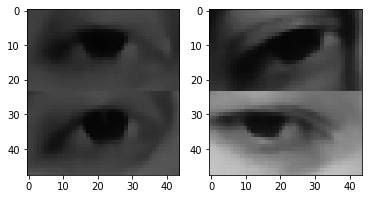

In [20]:
NUM = 1
print("Train")
sample_train = (int(yx_train[NUM] * y_scalers[0]),
                int(yy_train[NUM] * y_scalers[1]))
sample_train_hat = (int(yx_hat_train[NUM] * y_scalers[0]),
                    int(yy_hat_train[NUM] * y_scalers[1]))
print(sample_train)
print(sample_train_hat)

print("Test")
sample_test = (int(yx_test[NUM] * y_scalers[0]),
                int(yy_test[NUM] * y_scalers[1]))
sample_test_hat = (int(yx_hat_test[NUM] * y_scalers[0]),
                    int(yy_hat_test[NUM] * y_scalers[1]))
print(sample_test)
print(sample_test_hat)

_, ax = plt.subplots(1,2)
ax[0].imshow((x1_train[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)
ax[1].imshow((x1_test[NUM] * x1_scaler).astype(np.uint8).
           reshape((frame_height, frame_width)), cmap="gray",vmin=0, vmax=255)

In [17]:
# train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
# test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

In [18]:
model_x.save(trained_models_dir + f"model{MODEL_NUM}_x")
model_y.save(trained_models_dir + f"model{MODEL_NUM}_y")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model4_x/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model4_y/assets
